### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
# Loading Data
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

### NES-FD
NES is a score-based black box algorithm for adversarial attacks. It works almost identically to PGD but estimates the gradient using Natural Evolution Strategies rather than extracting it directly from the model. The estimation strategy is quite simple. NES approximates gradients by iteratively perturbing input images with random noise and observing the resulting changes in the model's predictions. This process mimics natural selection, where promising perturbations that lead to higher misclassification probabilities are amplified in subsequent iterations. By accumulating these perturbation-induced changes, NES effectively estimates gradients without requiring direct access to the model's internal parameters, making it particularly suitable for black-box adversarial attack scenarios. 

For one iteration of estimation:

$$
u_i \leftarrow \mathcal{N}(0_N, I_{N \times N})
$$
$$
g \leftarrow g + P(y|x + \sigma \cdot u_i) \cdot u_i
$$
$$
g \leftarrow g - P(y|x - \sigma \cdot u_i) \cdot u_i
$$

NES uses uses $L^∞$ Norm Perturbations similar to PGD.

In [6]:
def test_nes(model, test_loader, epsilon, alpha):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Epsilon: {epsilon}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            

            output_final, perturbed_data = nes_attack(image, model, init_pred, output, epsilon, alpha)
            _, final_pred = torch.max(output_final.data, 1)
            if torch.equal(final_pred, label):
                correct += 1
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
            
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            total +=1 
            print(f"{correct}/{total}")
            

    accuracy = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [7]:
# MNIST
accuracy, examples = test_nes(mnist_resnet_model, test_loader_mnist, 8, 0.01 )
print(accuracy)

Batch: 1, Epsilon: 8, Correct: 0
7 7 15.285808563232422  ,diff:  92.92862701416016
7 7 15.144009590148926  ,diff:  107.37252807617188
7 7 15.423689842224121  ,diff:  101.94356536865234
7 7 15.206236839294434  ,diff:  113.7379150390625
7 7 15.621082305908203  ,diff:  87.30177307128906
7 7 15.048015594482422  ,diff:  109.30345153808594
7 7 14.769824028015137  ,diff:  69.95709228515625
7 7 15.072145462036133  ,diff:  93.31088256835938
7 7 15.208332061767578  ,diff:  87.58024597167969
7 7 15.33874225616455  ,diff:  100.76663208007812
7 7 15.476858139038086  ,diff:  98.5856704711914
7 7 15.302431106567383  ,diff:  94.63262939453125
7 7 15.285634994506836  ,diff:  94.47023010253906
7 7 15.167536735534668  ,diff:  89.67774200439453
7 7 15.061856269836426  ,diff:  104.27871704101562
7 7 15.006876945495605  ,diff:  88.291015625
7 7 15.42301082611084  ,diff:  117.4801254272461
7 7 15.205526351928711  ,diff:  107.93376159667969
7 7 14.926629066467285  ,diff:  103.12708282470703
7 7 14.94160175323

KeyboardInterrupt: 

[]


TypeError: Invalid shape (0,) for image data

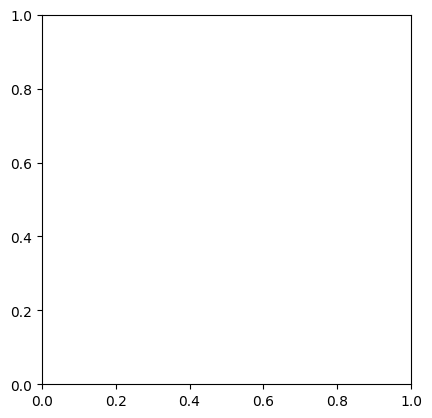

In [ ]:
# MNIST Viewer
print(examples)
plt.imshow(examples)

# plt.figure(figsize=(8, 10))
# for j in range(100):
#     plt.subplot(10, 10, j + 1)
#     plt.xticks([], [])
#     plt.yticks([], [])
#     orig, adv, ex = examples[j]
#     plt.title(f"{orig} -> {adv}")
#     plt.imshow(ex, cmap="gray")
# plt.tight_layout()
plt.show()